# Spam Text Classification Using Different Models

In this notebook we will do text classification.

**Problem:**

We'll identify if a text message is spam, or genuine.

**Problem Formulation:**

Binary classification on a fixed-length window of tokens.

**Data:**

Our data has 2 columns. The first column is the label and the second column is text message itself.

**Models / Techniques:**

- Embeddings
- SimpleRNN
- GRU
- LSTM
- Ensemble Model

## Libraries

We import the necessary packages. Keras for ML models / layers, pandas for data representation, and matplotlib for visualization on the loss values.

In [1]:
from keras.layers import SimpleRNN, Embedding, Dense, LSTM
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

## Dataset

Wget is a command line tool to download content from the web. We use the command line with the "!" symbol, and use wget to download our data.

In [2]:
!wget https://raw.githubusercontent.com/inzva/Applied-AI-Study-Group/master/Applied%20AI%20Study%20Group%20%233%20-%20June%202020/week2/SpamTextClassification/datasets_2050_3494_SPAM%20text%20message%2020170820%20-%20Data.csv


--2022-01-17 22:27:56--  https://raw.githubusercontent.com/inzva/Applied-AI-Study-Group/master/Applied%20AI%20Study%20Group%20%233%20-%20June%202020/week2/SpamTextClassification/datasets_2050_3494_SPAM%20text%20message%2020170820%20-%20Data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 480130 (469K) [text/plain]
Saving to: ‘datasets_2050_3494_SPAM text message 20170820 - Data.csv.1’

datasets_2050_3494_ 100%[===================>] 468.88K  --.-KB/s    in 0.04s   

2022-01-17 22:27:56 (12.7 MB/s) - ‘datasets_2050_3494_SPAM text message 20170820 - Data.csv.1’ saved [480130/480130]



Now the dataset is in the disk of our machine. We load the dataset from the disk.

In [3]:
data = pd.read_csv("datasets_2050_3494_SPAM text message 20170820 - Data.csv")

Our data has 2 columns. The first column is the label, and the second column is text message itself.

Let's see the first 20 rows of our data and read the messages:

In [4]:
data.head

<bound method NDFrame.head of      Category                                            Message
0         ham  Go until jurong point, crazy.. Available only ...
1         ham                      Ok lar... Joking wif u oni...
2        spam  Free entry in 2 a wkly comp to win FA Cup fina...
3         ham  U dun say so early hor... U c already then say...
4         ham  Nah I don't think he goes to usf, he lives aro...
...       ...                                                ...
5567     spam  This is the 2nd time we have tried 2 contact u...
5568      ham               Will ü b going to esplanade fr home?
5569      ham  Pity, * was in mood for that. So...any other s...
5570      ham  The guy did some bitching but I acted like i'd...
5571      ham                         Rofl. Its true to its name

[5572 rows x 2 columns]>

What do you think, which ones look like spam messages?

Let's count how many spam and non-spam messages there are.

In [5]:
texts = []
labels = []
for i, label in enumerate(data['Category']):
    texts.append(data['Message'][i])
    if label == 'ham':
        labels.append(0)
    else:
        labels.append(1)

texts = np.asarray(texts)
labels = np.asarray(labels)


print("number of texts :" , len(texts))
print("number of labels: ", len(labels))

number of texts : 5572
number of labels:  5572


In [6]:
labels

array([0, 0, 1, ..., 0, 0, 0])

In [7]:
hamc= sum(labels==0)

In [8]:
spamc=sum(labels==1)

In [9]:
spamc /(hamc+spamc)

0.13406317300789664

### Data Imbalance

Data is imbalanced. Making it even more imbalanced by removing some of the spam messages and observing the model performance would be a good exercise to explore imbalanced dataset problem in Sequential Model context.

In [10]:
texts

array(['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
       'Ok lar... Joking wif u oni...',
       "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
       ..., 'Pity, * was in mood for that. So...any other suggestions?',
       "The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free",
       'Rofl. Its true to its name'], dtype='<U910')

## Data Preprocessing

In the dataset, each sentence has different lengths. To be able to parallelize (vectorization) the training process, we need to pad the sentences to the same length.

Also, we tokenize our sentences to be able to look-up their meaning vectors from our Embedding layer. Remember the Word2Vec example we did.

As a concerete example, we have following sentences
- 'Go until jurong point crazy'
- 'any other suggestions'

First we will do tokenization:

- [5, 10, 26, 67, 98]
- [7, 74, 107]

Now we have two integer lists with different length. We need to make them have the same length. 

### Post Padding
- [5, 10, 26, 67, 98]
- [7, 74, 107, 0, 0]

### Pre Padding
- [5, 10, 26, 67, 98]
- [0, 0, 7, 74, 107]

You don't have to use padding for all tasks out there. For details, refer to this link: https://github.com/keras-team/keras/issues/2375

In [11]:
from keras.layers import SimpleRNN, Embedding, Dense, LSTM
from keras.models import Sequential

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# number of words in our vocabulary 
max_features = 10000

# how many words from each document (max)?
maxlen = 500

## Train - Test Split

We will take a simple approach and create only train and test sets. If you want to do hyperparameter tuning, remember to also create a validation set to tune the hyperparameters on.

In [12]:
training_samples = int(len(labels)*0.8)
training_samples

4457

In [13]:
validation_samples = int(5572 - training_samples)

In [14]:
assert len(labels) == (training_samples + validation_samples), "Not equal!"

In [15]:
print("The number of training {0}, validation {1} ".format(training_samples, validation_samples))

The number of training 4457, validation 1115 


## Tokenization

- We create a tokenizer
- Fit it into our text (it makes a statistical analysis on how to tokenize)
- Transform the text sentences into lists of tokens
- Print how many unique words we have in our vocab 

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print("Found {0} unique words: ".format(len(word_index)))

Found 9004 unique words: 


We pad the sentences as we've mentioned in the preprocessing part.

In [17]:
#data = pad_sequences(sequences, maxlen=maxlen, padding='post')
data = pad_sequences(sequences, maxlen=maxlen)
print(data.shape)

(5572, 500)


In [18]:
data

array([[   0,    0,    0, ...,   58, 4427,  144],
       [   0,    0,    0, ...,  472,    6, 1940],
       [   0,    0,    0, ...,  660,  391, 2994],
       ...,
       [   0,    0,    0, ...,  107,  250, 9003],
       [   0,    0,    0, ...,  198,   12,   47],
       [   0,    0,    0, ...,    2,   61,  267]], dtype=int32)

We shuffle the data and split the training / test set.

In [19]:
np.random.seed(42)
# shuffle data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]


texts_train = data[:training_samples]
y_train = labels[:training_samples]
texts_test = data[training_samples:]
y_test = labels[training_samples:]

## Building Models and Training them

We will create 3 different models and compare their performances. One model will use SimpleRNN layer, the other will use GRU layer and the last one will use LSTM layer. Architecture of each model is the same. We can create deeper models but we already get good results.

### Simple RNN

We define model layers, build the (compile) the model, and train it.

In [20]:
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', 
             metrics=['acc'])

history_rnn = model.fit(texts_train, y_train, epochs=10,
                       batch_size=60, validation_split=0.2)

Epoch 1/10
60/60 [==============================] - 32s 508ms/step - loss: 0.3854 - acc: 0.8656 - val_loss: 0.1798 - val_acc: 0.9608
Epoch 2/10
60/60 [==============================] - 29s 486ms/step - loss: 0.1196 - acc: 0.9714 - val_loss: 0.0802 - val_acc: 0.9742
Epoch 3/10
60/60 [==============================] - 30s 508ms/step - loss: 0.0648 - acc: 0.9815 - val_loss: 0.0893 - val_acc: 0.9686
Epoch 4/10
60/60 [==============================] - 30s 495ms/step - loss: 0.0345 - acc: 0.9919 - val_loss: 0.0481 - val_acc: 0.9877
Epoch 5/10
60/60 [==============================] - 29s 478ms/step - loss: 0.0266 - acc: 0.9924 - val_loss: 0.0622 - val_acc: 0.9798
Epoch 6/10
60/60 [==============================] - 29s 479ms/step - loss: 0.0172 - acc: 0.9938 - val_loss: 0.0603 - val_acc: 0.9809
Epoch 7/10
60/60 [==============================] - 30s 502ms/step - loss: 0.0102 - acc: 0.9966 - val_loss: 0.0870 - val_acc: 0.9787
Epoch 8/10
60/60 [==============================] - 30s 493ms/step - 

We plot accuracies and losses against epochs

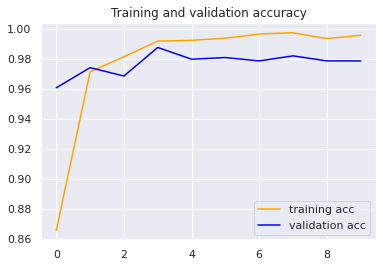

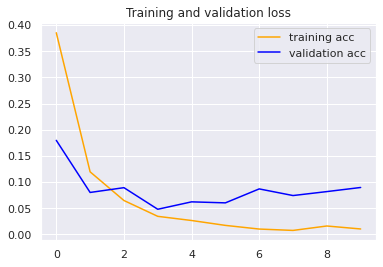

In [21]:
acc, val_acc = history_rnn.history['acc'], history_rnn.history['val_acc']
loss, val_loss = history_rnn.history['loss'], history_rnn.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, '-', color='orange', label='training acc')
plt.plot(epochs, val_acc, '-', color='blue', label='validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, '-', color='orange', label='training acc')
plt.plot(epochs, val_loss,  '-', color='blue', label='validation acc')
plt.title('Training and validation loss')
plt.legend()
plt.show()

We plot precision against recall. (blue)

We also plot precision against thresholds to see the corresponding threshold value for each precision|recall pair. (orange)

Text(0, 0.5, 'Blue: Recall, Orange: Thresholds')

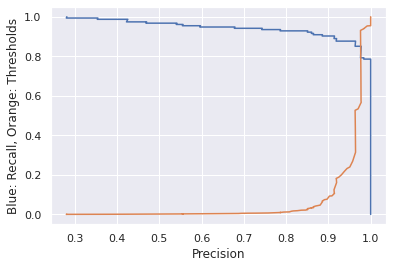

In [90]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, ConfusionMatrixDisplay

scores = model.predict(texts_test)
precision, recall, thresholds = precision_recall_curve(y_test, scores)

plt.plot(precision,recall)
plt.plot(precision, np.append(thresholds,1))
plt.xlabel("Precision")
plt.ylabel("Blue: Recall, Orange: Thresholds")

We want really high precision for this model. 

It's okay if we miss spam messages, but it is unacceptable to classify genuine mail as spam.

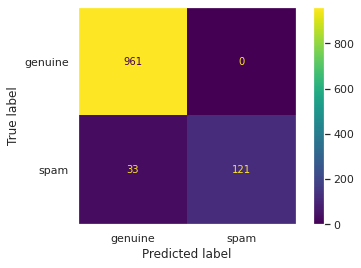

In [97]:
pred_class = np.array([1 if i >= 0.9536 else 0 for i in scores])
disp = ConfusionMatrixDisplay.from_predictions(y_test, pred_class, display_labels=["genuine","spam"])
plt.grid(False)
plt.show()

- With this threshold value, we classify no genuine mail as spam. 
- While ensuring that, we can catch 121/154 of the spam mails.
- So, it seems like we've found a nice threshold value.

## Homework: Try other models

- Try to use GRU and LSTM for the same task. That is the easy part.
- For the ones who would like to get more involved, try to use TFIDF algorithm to classify the texts!

### GRU

SimpleRNN, GRU, and LSTM are very similar to each other in terms of model use. 

- Try to define your own model, which includes a GRU layer
- Train it
- Evaluate it
- Select a threshold
- Report the final performance!

Does it perform better while still ensuring %100 precision?

### LSTM

SimpleRNN, GRU, and LSTM are very similar to each other in terms of model use. 

- Try to define your own model, which includes an LSTM layer
- Train it
- Evaluate it
- Select a threshold
- Report the final performance!

Does it perform better while still ensuring %100 precision?

Which one performs the best?

### TF-IDF Classification

Try to use the tfidf vectors in scikit-learn to classify the messages, instead of a deep learning approach! 

Compare the performance with the other models that we've used before.

You can refer to these documentation sections to build your sparse representation vectors, and then train a classifier on them:

* https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#extracting-features-from-text-files
* https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#training-a-classifier

After training your classifier, evaluate, select a threshold, and report the final performance.

Which one performs better? Deep Learning, or TFIDF?

- Preprocess the data into sklearn dataset format
- Count vectorize, TfIdfTransform fit, MultinomialNB fit
- Measure performance on test data

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_set)
X_train_counts.shape
# ...